In [56]:
import pandas as pd
import numpy as np
filepath = "/var/data/cgaydon/data/202110_building_val/metadata/emprises_reprises_nbreBatiSurdetection.csv"
df_split = pd.read_csv(filepath)
desc = df_split.groupby("split").describe(include=np.number)
desc = desc.transpose()
desc

split                   test        train         val
port       count   15.000000   120.000000   15.000000
           mean     0.066667     0.008333    0.000000
           std      0.258199     0.091287    0.000000
           min      0.000000     0.000000    0.000000
           25%      0.000000     0.000000    0.000000
           50%      0.000000     0.000000    0.000000
           75%      0.000000     0.000000    0.000000
           max      1.000000     1.000000    0.000000
nb_vehicul count   15.000000   120.000000   15.000000
           mean     8.866667     4.341667    2.400000
           std     31.320615    18.021227    8.757038
           min      0.000000     0.000000    0.000000
           25%      0.000000     0.000000    0.000000
           50%      0.000000     0.000000    0.000000
           75%      2.000000     1.000000    0.000000
           max    122.000000   136.000000   34.000000
nb_bati    count   15.000000   120.000000   15.000000
           mean   193.866667   145.783333   54.400000
           std    216.013514   229.194577   79.390356
           min      0.000000     0.000000    0.000000
           25%     34.500000    14.000000    3.500000
           50%    121.000000    40.000000   22.000000
           75%    253.500000   177.500000   58.500000
           max    698.000000  1466.000000  248.000000
nb_veget   count   15.000000   120.000000   15.000000
           mean    73.333333    38.250000   20.733333
           std    113.708692    79.898176   49.023998
           min      0.000000     0.000000    0.000000
           25%      5.000000     0.000000    0.000000
           50%     12.000000     4.500000    3.000000
           75%    116.000000    32.000000   11.500000
           max    297.000000   409.000000  189.000000
nb_autre   count   15.000000   120.000000   15.000000
           mean     4.066667     4.241667    2.066667
           std      5.637460     7.332437    2.737743
           min      0.000000     0.000000    0.000000
           25%      0.000000     0.000000    0.000000
           50%      1.000000     1.000000    1.000000
           75%      7.000000     5.000000    3.000000
           max     18.000000    44.000000    9.000000

In [57]:
df_split.groupby("split").sum()

,port,nb_vehicul,nb_bati,nb_veget,nb_autre
split,,,,,
test,1,133,2908,1100,61
train,1,521,17494,4590,509
val,0,36,816,311,31


In [54]:
outdir = "../logs/descriptions/"

In [2]:
import os.path as osp
from pathlib import Path
from typing import List, Union

import laspy
import numpy as np
from torch_geometric.data import Data

import pandas as pd
from torch_geometric.transforms import BaseTransform

def load_las_data(filepath):
    """Load a cloud of points and its labels. base shape: [n_points, n_features].
    Warning: las.x is in meters, las.X is in centimeters.
    """
    las = laspy.read(filepath)
    pos = np.asarray(
        [
            las.x,
            las.y,
            las.z,
        ],
        dtype=np.float32,
    )
    x = np.asarray(
        [
            las.intensity,
            las.return_num,
            las.num_returns,
        ],
        dtype=np.float32,
    )
    pos = pos.transpose()
    x = x.transpose()
    y = las.classification.astype(np.int)
    tile_id = Path(filepath).stem

    return Data(
        pos=pos,
        x=x,
        y=y,
        filepath=filepath,
        tile_id=tile_id,
    )

class MakeBuildingTargets(BaseTransform):
    """
    Pass from multiple classes to simpler Building/Non-Building labels.
    Initial classes: [  1,   2,   6 (detected building, no validation),  19 (valid building),  20 (surdetection, unspecified),
    21 (building, forgotten), 104, 110 (surdetection, others), 112 (surdetection, vehicule), 114 (surdetection, others), 115 (surdetection, bridges)]
    Final classes: 0 (non-building), 1 (building)
    """

    def __call__(self, data: Data):
        buildings_idx = (data.y == 19) | (data.y == 21) | (data.y == 6)
        data.y[buildings_idx] = 1
        data.y[~buildings_idx] = 0
        return data

In [29]:
def describe(filepath: str):
    """ Return a dict of descriptor of a LAS. """

    data = load_las_data(filepath)
    data = MakeBuildingTargets()(data)
    log = {}
    log.update({"tile_id" : data.tile_id})
    log.update({"file_path" : data.filepath})
    log.update({"num_points":data.y.shape[0]})
    log.update({"pos.shape":data.pos.shape})
    log.update({"x.shape":data.x.shape})
    log.update({"y.shape":data.y.shape})
    try:
        low = data.pos[:, :2].min(0)
        high = data.pos[:, :2].max(0)
        log.update({"min_xy_meters":str(low)})
        log.update({"max_xy_meters":str(high)})
        log.update({"range_xy_meters":str(high - low)})
    except:
        print(f"min cannot be calculated for {data.filepath}")
    
    log.update({"PercBuilding": f"{data.y.mean()}"})
    return log

logs = []
i = 1
for filepath in df_split.file_path.values:
    log = describe(filepath)
    logs.append(log)
    if i % 10 == 0:
        print(i)
    i+=1
    

/tmp/ipykernel_66933/3555966106.py:38: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y = las.classification.astype(np.int)


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150


In [30]:
df_logs = pd.DataFrame(data=logs)
df_logs.to_csv(f"{outdir}dataset_description.csv")

In [46]:
df_described = pd.merge(df_split, df_logs, on="file_path")
df_described.PercBuilding = df_described.PercBuilding.astype(float)
df_described.to_csv(f"{outdir}dataset_description_full.csv")

## Visualize

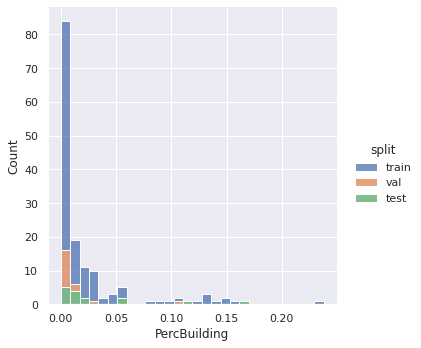

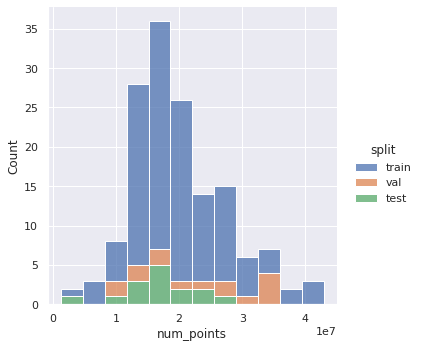

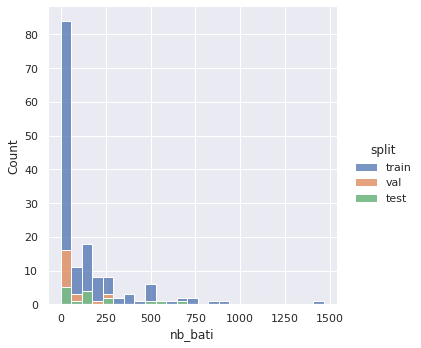

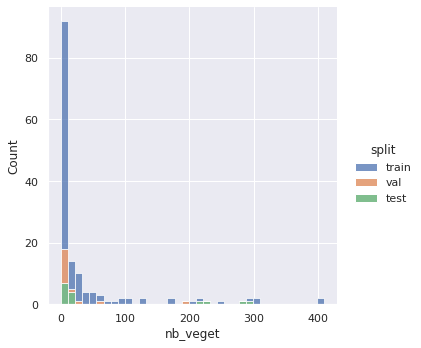

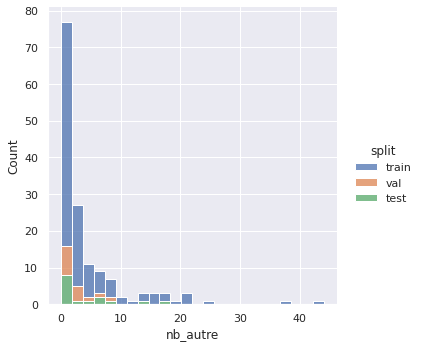

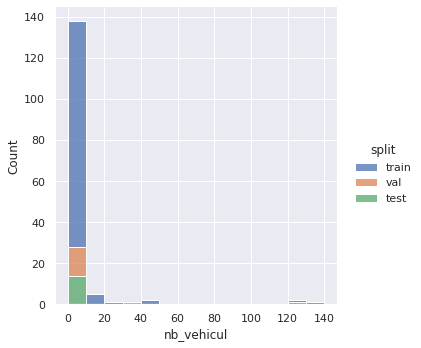

In [55]:
import seaborn as sns; sns.set();
import matplotlib.pyplot as plt

for coln in ["PercBuilding", "num_points", "nb_bati", "nb_veget", "nb_autre"]:
    sns.displot(data=df_described, x=coln, hue="split",multiple="stack")
    plt.savefig(f"{outdir}/{coln}.png")

coln = "nb_vehicul"
sns.displot(data=df_described, x=coln, hue="split",multiple="stack", binwidth=10)
plt.savefig(f"{outdir}/{coln}.png")

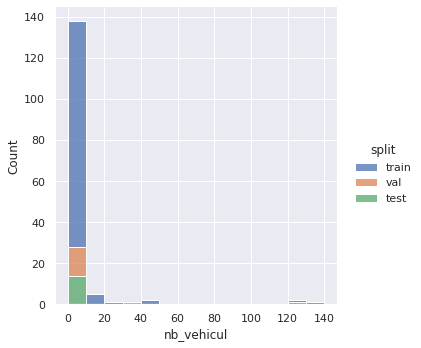

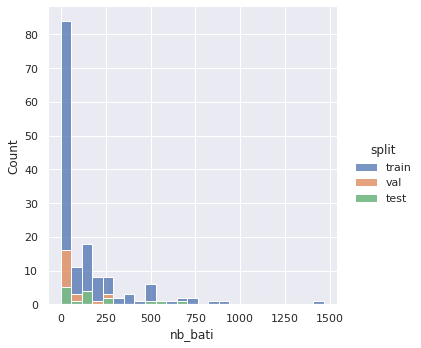

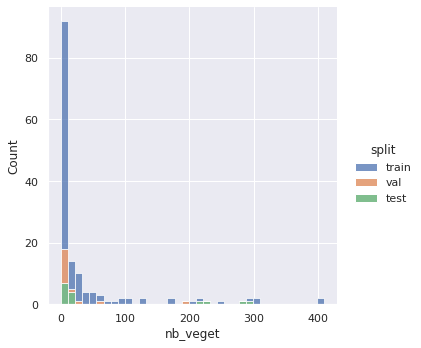

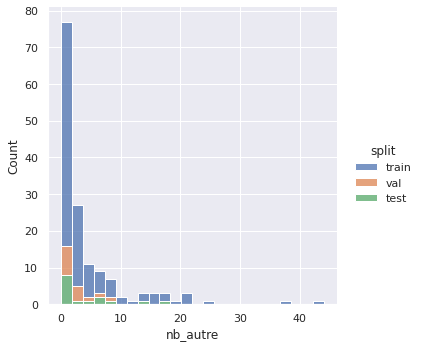

In [50]:
df_described.columns

Index(['layer', 'file', 'port', 'nb_vehicul', 'nb_bati', 'nb_veget',
       'nb_autre', 'split', 'file_path', 'tile_id', 'num_points', 'pos.shape',
       'x.shape', 'y.shape', 'min_xy_meters', 'max_xy_meters',
       'range_xy_meters', 'PercBuilding'],
      dtype='object')

In [44]:
df_described.PercBuilding.astype(float).describe()

count    150.000000
mean       0.023694
std        0.041383
min        0.000000
25%        0.000862
50%        0.006196
75%        0.023770
max        0.238006
Name: PercBuilding, dtype: float64